## Step 1: Import the necessary libraries

Here we will import the necessary libraries that will be used to build the k-NN model and this whole assignment.

In [223]:
import os
import random
import cv2 as cv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
import nbformat

## Step 2: Load the CIFAR-10 training dataset 

In this step, we will load the CIFAR-10 dataset from the workspace directory. Also show the class names of the dataset.<br><br>
<b>N.B: Edit the directory path with your directory for the dataset.</b>

In [2]:
TRAIN_DIR = 'M:/Dataset/CIFAR-10-images/train'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Here, we will read and store every images from each class folder and record them under the TRAIN_DATA. Later we will be using this TRAIN_DATA for further model building.

In [3]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv.imread(os.path.join(path,img))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7947.73it/s]

50000


## Step 3: Converting the images into Grayscale and Show as Plot 

First we will convert all the images into grayscale. Then we will randomly select some of the images from the TRAIN_DATA and show them in a subplot with class lebels.

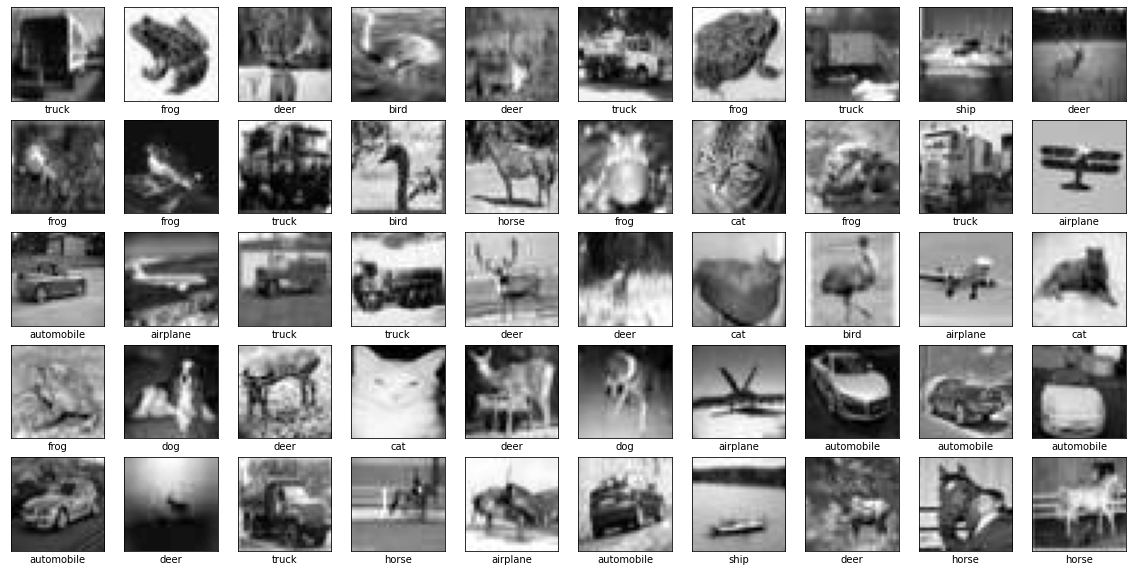

In [146]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20,10))

for i in range(50):
    plt.subplot(5,10,i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert image to grayscale
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

## Step 4: Defining 5-fold validation folds

Here we will define 5 folds of the data and split them as 1000 images per fold.

In [5]:
f0 = TRAIN_DATA[0:1000]
f1 = TRAIN_DATA[1000:2000]
f2 = TRAIN_DATA[2000:3000]
f3 = TRAIN_DATA[3000:4000]
f4 = TRAIN_DATA[4000:5000]

## Step 5: Defining k-values, L1 and L2 distances

We will use k-values ranging from 1 to 20.<br>
Also define the functions for L1 and L2 distance for k-NN model.

In [222]:
k_max = 20

def l1_dist(x, y):
    return np.sum(np.abs(x - y))

def l2_dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

## Step 6: Model training for k-NN Classification

Here we will train the model and calculate the accuracies for both L1 and L2 distance.<br>
Also, we will show the progress for each fold of each class while training.

In [6]:
mean_accuracies_l1 = []
std_accuracies_l1 = []
mean_accuracies_l2 = []
std_accuracies_l2 = []

for class_idx, class_name in enumerate(CATEGORIES):
    class_fold_accuracies_l1 = []
    class_fold_accuracies_l2 = []

    for fold in tqdm(range(5), desc=f'Progress for Class -----> "{class_name}"'):
        fold_accuracies_l1 = []
        fold_accuracies_l2 = []

        if fold == 0:
            train = f1 + f2 + f3 + f4
            validation = f0
        elif fold == 1:
            train = f0 + f2 + f3 + f4
            validation = f1
        elif fold == 2:
            train = f0 + f1 + f3 + f4
            validation = f2
        elif fold == 3:
            train = f0 + f1 + f2 + f4
            validation = f3
        elif fold == 4:
            train = f0 + f1 + f2 + f3
            validation = f4

        acc_l1 = 0
        acc_l2 = 0

        for v in validation:
            l1_dists = []
            l2_dists = []
            for t in train:
                l1 = l1_dist(v[0], t[0])
                l2 = l2_dist(v[0], t[0])
                l1_dists.append((l1, t[1]))
                l2_dists.append((l2, t[1]))
            l1_dists.sort(key=lambda x: x[0])
            l2_dists.sort(key=lambda x: x[0])

            neighbors_l1 = [d[1] for d in l1_dists[:k_max]]
            counts_l1 = np.bincount(neighbors_l1)
            pred_l1 = np.argmax(counts_l1)

            neighbors_l2 = [d[1] for d in l2_dists[:k_max]]
            counts_l2 = np.bincount(neighbors_l2)
            pred_l2 = np.argmax(counts_l2)

            if pred_l1 == v[1]:
                acc_l1 += 1
            if pred_l2 == v[1]:
                acc_l2 += 1

        fold_accuracies_l1.append(acc_l1 / len(validation))
        fold_accuracies_l2.append(acc_l2 / len(validation))

    mean_accuracies_l1.append(np.mean(fold_accuracies_l1))
    std_accuracies_l1.append(np.std(fold_accuracies_l1))
    mean_accuracies_l2.append(np.mean(fold_accuracies_l2))
    std_accuracies_l2.append(np.std(fold_accuracies_l2))

Progress for Class -----> "truck": 100%|████████████████████████████████████████████████| 5/5 [08:52<00:00, 106.59s/it]


In [217]:
with open('vals.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)
cell_index = 0  # Adjust this index to the appropriate cell that defines the variables
cell = nb['cells'][cell_index]
exec(''.join(cell['source']), globals())

## Step 7: Plotting the accuracy results of L1 and L2 distance

The results we got from the previous step, has been recorded in lists. Now we will try to show the accuracy vs. k-value plot for both L1 and L2 distance.<br>
With that plot information, we would be able to see which k-values are performing better for which distance metric.

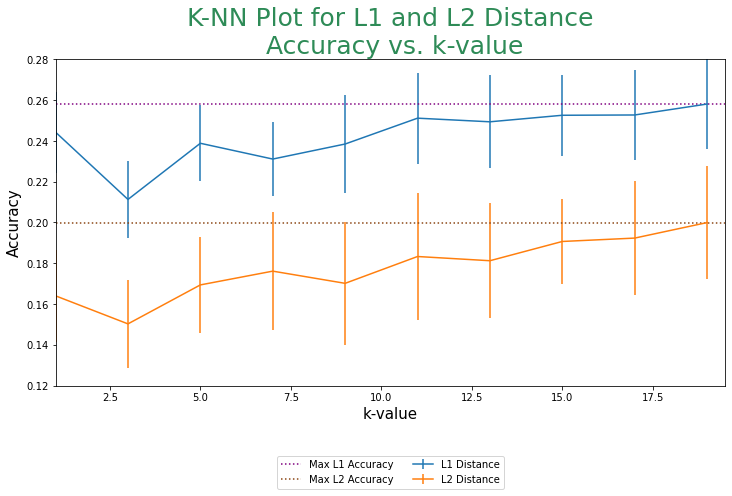

In [231]:
plt.figure(figsize=(12, 6))  # Adjust the width and height as desired
plt.errorbar(range(1, k_max, 2), mean_accuracies_l1, yerr=std_accuracies_l1, label="L1 Distance")
plt.errorbar(range(1, k_max, 2), mean_accuracies_l2, yerr=std_accuracies_l2, label="L2 Distance")
plt.xlabel("k-value", size=15)
plt.ylabel("Accuracy", size=15)
plt.title("K-NN Plot for L1 and L2 Distance\n Accuracy vs. k-value", size=25, color="seagreen")
plt.xlim(1, 19.5)  # Set the x-axis limits
plt.ylim(0.12, 0.28)  # Set the y-axis limits
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

max_accuracy_l1 = max(mean_accuracies_l1)
max_accuracy_l2 = max(mean_accuracies_l2)
plt.axhline(y=max_accuracy_l1, linestyle='dotted', color='purple', label='Max L1 Accuracy')
plt.axhline(y=max_accuracy_l2, linestyle='dotted', color='saddlebrown', label='Max L2 Accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

plt.show()

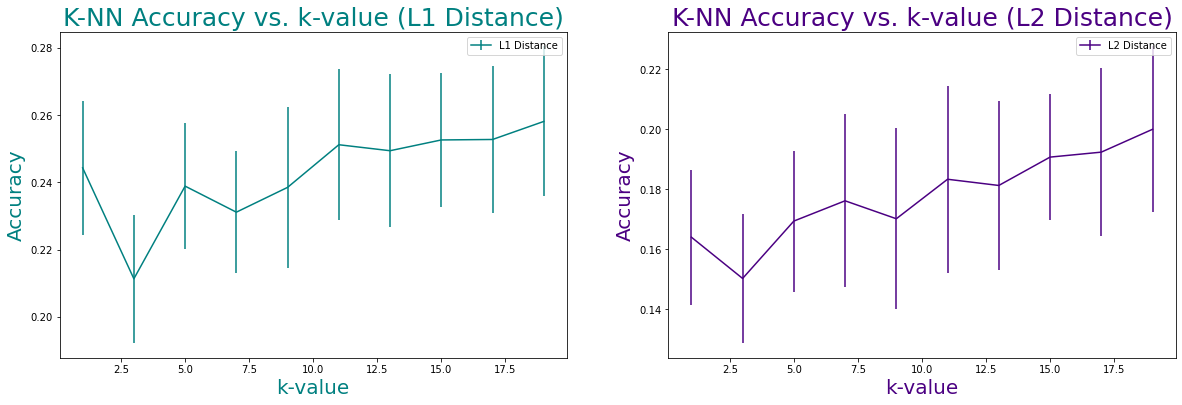

In [232]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# Plot for L1 distance
ax1.errorbar(range(1, k_max+1,2), mean_accuracies_l1, yerr=std_accuracies_l1, label="L1 Distance", color="teal")
ax1.set_xlabel("k-value", size=20, color="teal")
ax1.set_ylabel("Accuracy", size=20, color="teal")
ax1.set_title("K-NN Accuracy vs. k-value (L1 Distance)", size=25, color="teal")
ax1.legend()

# Plot for L2 distance
ax2.errorbar(range(1, k_max+1,2), mean_accuracies_l2, yerr=std_accuracies_l2, label="L2 Distance", color="indigo")
ax2.set_xlabel("k-value", size=20, color="indigo")
ax2.set_ylabel("Accuracy", size=20, color="indigo")
ax2.set_title("K-NN Accuracy vs. k-value (L2 Distance)", size=25, color="indigo")
ax2.legend()
plt.show()

## Step 8: Display top 5 predictions on test images 

Here we will try to show the top 5 image predictions by L1 and L2 distance. Each prediction will contain the class name that the model predicted, and the distance it calculated for that value.<br><br>
<b>  N.B: As we are not using the test data, only the train data, so at least one of the predicted image's distance will be always zero. Because the model trained under the same test data.</b>

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'airplane' with L1 distance 0.00
Prediction 2: Class 'airplane' with L1 distance 589.48
Prediction 3: Class 'airplane' with L1 distance 601.94
Prediction 4: Class 'horse' with L1 distance 610.54
Prediction 5: Class 'airplane' with L1 distance 621.43

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'airplane' with L2 distance 0.00
Prediction 2: Class 'horse' with L2 distance 293.99
Prediction 3: Class 'ship' with L2 distance 294.27
Prediction 4: Class 'deer' with L2 distance 296.75
Prediction 5: Class 'ship' with L2 distance 296.92


	Some Predicted Images by the k-NN model	:


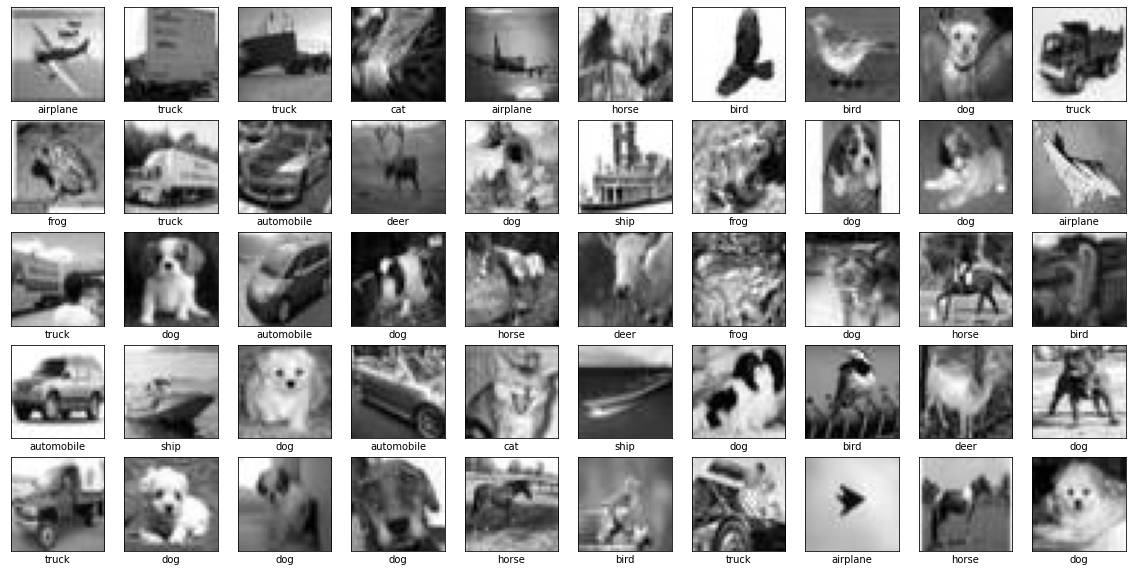

In [240]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20, 10))

for i in range(50):
    plt.subplot(5, 10, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert image to grayscale
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49:  # Corrected the condition to break the loop
        break

test_images = []  # Initialize an empty list to store the test images

for i in range(2000):
    test_image = TRAIN_DATA[i][0]  # Get the image from TRAIN_DATA at index i
    test_image_gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)  # Convert test image to grayscale
    test_images.append(test_image_gray)  # Add the grayscale image to the test_images list

# Now you have a list named test_images containing 200 randomly selected grayscale test images from TRAIN_DATA.

# Display top L1 Distance 5 predictions
print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images:
    distances1 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)  # Convert training image to grayscale
        dist1 = l1_dist(test_image_gray, train_image_gray)  # Calculate L1 distance
        distances1.append((dist1, class_num))
    
    distances1.sort(key=lambda x: x[0])  # Sort distances in ascending order
    
    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")
    break

# Display top L2 Distance 5 predictions
print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images:
    distances2 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)  # Convert training image to grayscale
        dist2 = l2_dist(test_image_gray, train_image_gray)  # Calculate L1 distance
        distances2.append((dist2, class_num))
    
    distances2.sort(key=lambda x: x[0])  # Sort distances in ascending order
    
    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")
    
    print(f"\n\n\tSome Predicted Images by the k-NN model\t:")
    plt.show()
    break

# Discussion

In this project, we compared the performance of Manhattan (L1) and Euclidean (L2) distances based on the average accuracy values obtained from the 5-fold cross-validation. Our analysis aimed to determine which distance calculation technique is better suited for the given gray-scale dataset.
<br><br>
The dataset's characteristics, such as the nature of the features and the complexity of the classes, played a crucial role in evaluating the performance of the distance metrics. L1 distance, also known as Manhattan distance, calculates the sum of absolute differences between corresponding elements of two vectors. On the other hand, L2 distance, also known as Euclidean distance, calculates the square root of the sum of squared differences between corresponding elements.
<br><br>
Based on our analysis, we found that the L1 distance metric performed slightly better in terms of accuracy compared to the L2 distance metric. This result suggests that for this specific gray-scale dataset, where features are represented as pixel intensities, the L1 distance metric may capture the differences between images more effectively.
<br><br>
However, it is important to note that the choice of distance metric may vary depending on the dataset and the specific problem at hand. Other factors, such as the dimensionality of the data and the presence of outliers, should also be considered when selecting an appropriate distance metric.
<br><br>
Regarding limitations and potential improvements, it is worth mentioning that our analysis focused solely on the distance metrics and did not consider other aspects such as feature selection, dimensionality reduction techniques, or more advanced classification algorithms. Exploring these avenues could potentially lead to further improvements in classification accuracy.
<br><br>
In conclusion, our comparison of Manhattan (L1) and Euclidean (L2) distances highlighted the importance of considering dataset characteristics and feature nature when selecting a distance calculation technique. The slightly better performance of L1 distance in this gray-scale dataset suggests its suitability for capturing image differences. However, further investigations incorporating additional techniques could be explored to enhance classification accuracy.
<br><br>